## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm
from transformers import DistilBertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3
from bert import CustomBert3, CustomBert5, CustomBert3b
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train['question'] = train['question_title'] + ' \n \n \n ' + train['question_body']
test['question'] = test['question_title'] + ' \n \n \n ' + test['question_body']

In [4]:
%%time
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer']:
        ids = []
        for x in tqdm(df[text].values):
            encoded_inputs = tokenizer.encode_plus(
                x, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)
            ids.append(encoded_inputs['input_ids'])
        if mode == 'train': ids_train[text] = np.array(ids)
        else: ids_test[text] = np.array(ids)

100%|██████████| 476/476 [00:00<00:00, 491.91it/s]

CPU times: user 26.4 s, sys: 129 ms, total: 26.5 s
Wall time: 26.8 s


In [5]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [6]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
y = train[TARGETS].values.astype(np.float32)

In [8]:
num_workers = 10
bs = 2

In [9]:
bs_test = 2
test_loader = DataLoader(
    TextDataset3(cat_features_test, ids_test['question'], ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

## Training model

In [10]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'double_distil_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [11]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_bert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.a_bert, lr / 100, weight_decay)
    )

Fold 1 started at Wed Jan  1 22:06:12 2020
CustomBert3(
  (q_bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn):

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


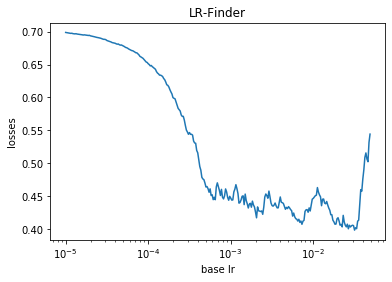

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42491 - spearmanr 0.19475
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38292 - spearmanr 0.35515
best model: epoch 0 - 0.35515
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.36942 - spearmanr 0.37422
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.3699 - spearmanr 0.4141
best model: epoch 1 - 0.4141
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35302 - spearmanr 0.44804
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36838 - spearmanr 0.42278
best model: epoch 2 - 0.42278
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34091 - spearmanr 0.50158
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36899 - spearmanr 0.43305
best model: epoch 3 - 0.43305
TRAINING END: Best score achieved on epoch 3 - 0.43305
Starting inference for model: checkpoints/double_distil_bert_fold_1_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_1_best.pth



Fold 2 started at Wed Jan  1 22:26:54 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42361 - spearmanr 0.19846
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.39356 - spearmanr 0.33387


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.33387
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.36955 - spearmanr 0.37631
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37168 - spearmanr 0.38759
best model: epoch 1 - 0.38759
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35284 - spearmanr 0.44318
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36761 - spearmanr 0.40131
best model: epoch 2 - 0.40131
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34088 - spearmanr 0.49996
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36803 - spearmanr 0.40516
best model: epoch 3 - 0.40516
TRAINING END: Best score achieved on epoch 3 - 0.40516
Starting inference for model: checkpoints/double_distil_bert_fold_2_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_2_best.pth



Fold 3 started at Wed Jan  1 22:46:07 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42429 - spearmanr 0.19525
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.38218 - spearmanr 0.36007
best model: epoch 0 - 0.36007
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.3706 - spearmanr 0.37273
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36683 - spearmanr 0.39575
best model: epoch 1 - 0.39575
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35442 - spearmanr 0.44212
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36445 - spearmanr 0.42052
best model: epoch 2 - 0.42052
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.3421 - spearmanr 0.49932
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36418 - spearmanr 0.42319
best model: epoch 3 - 0.42319
TRAINING END: Best score achieved on epoch 3 - 0.42319
Starting inference for model: checkpoints/double_distil_bert_fold_3_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_3_best.pth



Fold 4 started at Wed Jan  1 23:06:13 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42413 - spearmanr 0.20143
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.37539 - spearmanr 0.35337
best model: epoch 0 - 0.35337
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.37071 - spearmanr 0.37194
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.37047 - spearmanr 0.38743
best model: epoch 1 - 0.38743
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35426 - spearmanr 0.44533
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.36424 - spearmanr 0.40285
best model: epoch 2 - 0.40285
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34209 - spearmanr 0.50319
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36521 - spearmanr 0.40928
best model: epoch 3 - 0.40928
TRAINING END: Best score achieved on epoch 3 - 0.40928
Starting inference for model: checkpoints/double_distil_bert_fold_4_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_4_best.pth



Fold 5 started at Wed Jan  1 23:26:11 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.42301 - spearmanr 0.20189
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.3799 - spearmanr 0.34568
best model: epoch 0 - 0.34568
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.36923 - spearmanr 0.37952
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.36975 - spearmanr 0.38898
best model: epoch 1 - 0.38898
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.35321 - spearmanr 0.44588
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.37036 - spearmanr 0.39234
best model: epoch 2 - 0.39234
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.34089 - spearmanr 0.50357
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.36806 - spearmanr 0.3998
best model: epoch 3 - 0.3998
TRAINING END: Best score achieved on epoch 3 - 0.39980
Starting inference for model: checkpoints/double_distil_bert_fold_5_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_5_best.pth



OOF score: 0.41209407543422205


In [12]:
init_seed()
folds = GroupKFold(n_splits=5).split(
    X=train['question_body'], groups=train['question_body'])#KFold(n_splits=5, random_state=42).split(train)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset3(cat_features_train, ids_train['question'], ids_train['answer'], train_index, y),
        batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        TextDataset3(cat_features_train, ids_train['question'], ids_train['answer'], valid_index, y),
        batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / 5
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4134


In [17]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

from scipy.stats import spearmanr
def spearmanr_np(preds, targets):
    score = 0
    for i in range(N_TARGETS):
        score_i = spearmanr(preds[:, i], targets[:, i]).correlation
        score += np.nan_to_num(score_i / N_TARGETS)
    return score

In [44]:
zero_idx = np.where(y.mean(axis=0).round(3)<=0.001)[0][0]

In [21]:
my_round(oofs, 3, 2), oofs

(array([[0.96, 0.69, 0.15, ..., 0.09, 0.81, 0.9 ],
        [0.96, 0.78, 0.03, ..., 0.03, 0.54, 0.93],
        [0.93, 0.51, 0.  , ..., 0.15, 0.54, 0.96],
        ...,
        [0.87, 0.48, 0.  , ..., 0.12, 0.24, 0.75],
        [0.96, 0.69, 0.54, ..., 0.09, 0.87, 0.96],
        [0.93, 0.75, 0.03, ..., 0.03, 0.96, 0.93]]),
 array([[0.96354288, 0.68958771, 0.13741326, ..., 0.08092178, 0.81129986,
         0.91418678],
        [0.96740657, 0.79423517, 0.03735004, ..., 0.04122473, 0.54989547,
         0.94297105],
        [0.92234302, 0.50902313, 0.00296354, ..., 0.13869783, 0.52878088,
         0.95377809],
        ...,
        [0.8615889 , 0.47273153, 0.00226543, ..., 0.12887214, 0.22512965,
         0.75479412],
        [0.94618988, 0.70396459, 0.52556556, ..., 0.07803656, 0.86525667,
         0.95057601],
        [0.93261498, 0.76451313, 0.03763026, ..., 0.02630778, 0.95035845,
         0.93711549]]))

In [23]:
round_preds(oofs)

array([[0.96, 0.69, 0.15, ..., 0.09, 0.81, 0.9 ],
       [0.96, 0.78, 0.03, ..., 0.03, 0.54, 0.93],
       [0.93, 0.51, 0.  , ..., 0.15, 0.54, 0.96],
       ...,
       [0.87, 0.48, 0.  , ..., 0.12, 0.24, 0.75],
       [0.96, 0.69, 0.54, ..., 0.09, 0.87, 0.96],
       [0.93, 0.75, 0.03, ..., 0.03, 0.96, 0.93]])

5894

In [51]:
spearmanr_np(oofs, y)

(0.40157124223321455, 0.3994471633015957)

In [55]:
spearmanr_np(np.clip(round_preds(oofs, high_num=2), 0.00001, 0.999999), y)

0.417109142427779

In [ ]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [ ]:
sample_submission.head()